## NLP mini-project

- kaggle: https://www.kaggle.com/samdeeplearning/deepnlp?select=Sheet_1.csv
- 이런 데이터도 있었다. https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set

- 데이터 이해
- 문장 전처리 (int factor로 변환, 길이 맞추기-padding)
- word embedding을 포함한 모형 설계
- training

### 데이터 이해

Sheet1.csv contains 80 user responses, in the responsetext column, to a therapy chatbot. Bot said: 'Describe a time when you have acted as a resource for someone else'.  User responded. If a response is 'not flagged', the user can continue talking to the bot. If it is 'flagged', the user is referred to help.
* Sheet1.csv에는 치료 챗봇에 대한 80개의 사용자 응답이 응답 텍스트 열에 포함되어 있습니다. Bot은 다음과 같이 말했다: '당신이 다른 사람을 위한 자원 역할을 했던 때를 묘사하라.' 사용자가 응답했습니다. 응답에 플래그가 지정되지 않은 경우 사용자는 계속해서 봇과 대화할 수 있습니다. 플래그가 '플래그'된 경우 사용자에게 도움말을 참조합니다.

Sheet2.csv contains 125 resumes, in the resumetext column. Resumes were queried from Indeed.com with keyword 'data scientist', location 'Vermont'. If a resume is 'not flagged', the applicant can submit a modified resume version at a later date. If it is 'flagged', the applicant is invited to interview.
* 시트 2.csv에는 재개 텍스트 열에 125개의 이력서가 들어 있습니다. 이력서는 Indeed.com에서 키워드 '데이터 사이언티스트', 위치 'Vermont'로 조회되었다. 이력서에 플래그가 지정되지 않은 경우, 신청자는 나중에 수정된 이력서 버전을 제출할 수 있습니다. 플래그가 '플래그'된 경우 지원자는 인터뷰에 초대됩니다.

이걸로 뭘 해야 하죠?
새 재개/응답은 플래그가 지정되거나 플래그가 지정되지 않은 것으로 분류합니다.
여기에는 이력서와 응답이라는 두 가지 데이터 세트가 있습니다. 데이터를 열차 세트와 테스트 세트로 분할하여 분류기의 정확도를 테스트합니다. 두 문제에 동일한 분류기를 사용하기 위한 보너스 포인트.

In [161]:
# 이용한 package 모음
import pandas as pd
import numpy as np

In [162]:
df = pd.read_csv("C:/Github Projects/DL-for-All/17. 딥러닝을 이용한 자연어 처리/mini project/0. data/Sheet_1.csv")
df2 = pd.read_csv("C:/Github Projects/DL-for-All/17. 딥러닝을 이용한 자연어 처리/mini project/0. data/Sheet_2.csv", encoding='unicode_escape')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
response_id      80 non-null object
class            80 non-null object
response_text    80 non-null object
Unnamed: 3       2 non-null object
Unnamed: 4       0 non-null float64
Unnamed: 5       1 non-null object
Unnamed: 6       0 non-null float64
Unnamed: 7       1 non-null object
dtypes: float64(2), object(6)
memory usage: 5.1+ KB
None


In [163]:
 df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
resume_id      125 non-null object
class          125 non-null object
resume_text    125 non-null object
dtypes: object(3)
memory usage: 3.0+ KB


In [164]:
print(df.head(2), df2.head(2))

  response_id        class                                      response_text  \
0  response_1  not_flagged              I try and avoid this sort of conflict   
1  response_2      flagged  Had a friend open up to me about his mental ad...   

  Unnamed: 3  Unnamed: 4 Unnamed: 5  Unnamed: 6 Unnamed: 7  
0        NaN         NaN        NaN         NaN        NaN  
1        NaN         NaN        NaN         NaN        NaN     resume_id        class                                        resume_text
0  resume_1  not_flagged  \rCustomer Service Supervisor/Tier - Isabella ...
1  resume_2  not_flagged  \rEngineer / Scientist - IBM Microelectronics ...


#### tensorflow 이용을 위해 numpy package로 불러오기

- label만 하면 되는 거였다.

df = np.loadtxt("C:/Github Projects/DL-for-All/17. 딥러닝을 이용한 자연어 처리/mini project/0. data/Sheet_1.csv", delimiter=",", dtype=np.str, usecols=(1, 2, 3, 5, 7), skiprows=1)<br />
print(df.shape, df\[0:5\], sep="\n")

sentenses = df\[:, 1:\]<br />
labels = df\[:, 0\]<br />
print(sentenses.shape, sentenses\[0:5\], labels.shape, labels\[0:5\], sep="\n\n")

### 전처리

In [165]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.0.0


1. split to sentenses and label, Ont-hot Encoding

한 번에 다 바꿔버리는 게 무식한 방법일까 / batch 뽑을 때마다 뽑은 것만 바꾸는 게 무식한 방법일까

처음은 한 번만 돌려도 되지만, 데이터가 많아지면 시간 엄청 걸릴 것이고,<br />
다른 건 한 번에 조금만 돌리지만, 반복해서 돌려지는 게 있을 것이고, 무엇보다 epoch를 이용하면서 어차피 다 돌리게 됨.

학습은 꽤 느린 방법론이니까 최대한 시간을 줄이는 방법으로 가는 게 맞을 것으로 보임.<br />
따라서 1번 선택

In [166]:
sentenses = []
for row in np.arange(df.shape[0]):
    sentense = ""
    bases = df.iloc[row, :].isna()
    for col in np.arange(2, df.shape[1]):
        if ~bases[col]:
            sentense += " " + df.iloc[row, col]
    sentenses.append(sentense)
for row in np.arange(df2.shape[0]):
    sentense = ""
    bases = df2.iloc[row, :].isna()
    for col in np.arange(2, df2.shape[1]):
        if ~bases[col]:
            sentense += " " + df2.iloc[row, col]
    sentenses.append(sentense)
print(sentenses[0])

 I try and avoid this sort of conflict


In [167]:
label1 = df.iloc[:, 1]
label2 = df2.iloc[:, 1]
labels = np.array(label1.append(label2))
print(label1[0:5], label2[0:5], labels[0:5], labels.shape, labels[df.shape[0]:df.shape[0] + 5], sep="\n")

0    not_flagged
1        flagged
2        flagged
3    not_flagged
4    not_flagged
Name: class, dtype: object
0    not_flagged
1    not_flagged
2    not_flagged
3    not_flagged
4        flagged
Name: class, dtype: object
['not_flagged' 'flagged' 'flagged' 'not_flagged' 'not_flagged']
(205,)
['not_flagged' 'not_flagged' 'not_flagged' 'not_flagged' 'flagged']


In [168]:
labels = np.where(labels == "not_flagged", 0, labels)
labels = np.where(labels == "flagged", 1, labels)
labels = np.int32(labels)
labels

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0])

2. data split

In [169]:
np.random.seed(3)
tf.random.set_seed(3)

In [170]:
train_s, test_s, train_l, test_l = train_test_split(sentenses, labels, test_size=0.2)
print(f"total: {len(sentenses)}, train: {len(train_s)}, test: {len(test_s)}",
      f"total: {len(labels)}, train: {len(train_l)}, test: {len(test_l)}",
      test_s[0], test_l[0], sep="\n")

total: 205, train: 164, test: 41
total: 205, train: 164, test: 41
Research associate with over 10 years progressive academic and industrial experience in molecular research and discovery. Advanced experience in creating new research protocols supporting ongoing studies and compiling data for presentation. Highly responsible and dedicated team player with excellent leadership and mulit-tasking skills.
0


3. tokenize

In [171]:
token = Tokenizer()
token.fit_on_texts(train_s)
# print(token.word_index)

In [172]:
token.document_count

164

추측하자면, test sentenses에 대한 sequence 변환은 train을 통해 만들어진 word_index에 있는 것들만을 기준으로 한다. 그래서 확실하게 fit이랑 to(alike transform)를 나눠놓은 듯하다.

In [173]:
x = token.texts_to_sequences(train_s)
print(train_s[0], x[0], sep="\n")

Community College of Vermont - Winooski VT 2007 to 2009
[3036, 5857, 728, 6, 132, 997, 2457, 66, 25, 98, 2047, 3932, 76, 12, 57, 35, 10, 20, 20, 48, 31, 3036, 5858, 5859, 324, 33, 240, 728, 6, 132, 997, 2457, 66, 25, 98, 2047, 2458, 2459, 677, 3933, 3934, 3, 5860, 16, 324, 3935, 2, 133, 3037, 43, 851, 14, 7, 66, 25, 98, 1, 16, 324, 1551, 6, 7, 1552, 852, 2, 926, 43, 851, 415, 5861, 5862, 1756, 5863, 76, 12, 44, 110, 2, 114, 5864, 3038, 3936, 3937, 3039, 91, 44, 120, 2, 79, 5865, 214, 1, 781, 3938, 134, 2460, 3939, 5866, 3940, 14, 158, 14, 1553, 3, 3941, 1230, 5867, 183, 4, 438, 1, 11, 215, 6, 5868, 3942, 927, 1, 3943, 325, 998, 5869, 3944, 3936, 3937, 3039, 91, 50, 120, 2, 44, 5870, 462, 3, 2461, 1101, 3, 2460, 3939, 5871, 782, 204, 1, 198, 33, 5872, 3945, 5873, 5874, 1, 171, 5875, 6, 19, 292, 1, 194, 5876, 3038, 3946, 3947, 999, 1, 1102, 91, 50, 127, 2, 50, 5877, 171, 563, 256, 102, 34, 1385, 257, 1, 480, 176, 1, 1000, 11, 23, 5878, 11, 1, 5879, 5880, 3944, 3946, 3947, 999, 1, 1102, 9

다음 연산을 쉽게 하기 위해 변수로 저장

In [174]:
word_count = len(token.word_index) + 1

In [175]:
max_value = len(x[0])
for idx in np.arange(1, len(x)):
    if (max_value < len(x[idx])):
        max_value = len(x[idx])
        print(idx, max_value)

1 930
3 1438
29 2550
135 2551


4. padding

In [176]:
x = pad_sequences(x, max_value)
print(x[0])

[   0    0    0 ...  153    2 3042]


### word embedding을 포함한 모형 설계

In [177]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout #, Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping

In [178]:
stopping = EarlyStopping(patience=10, monitor="val_loss")

In [179]:
model = Sequential()
model.add(Embedding(word_count, 10, input_length=max_value))
model.add(Conv1D(32, kernel_size=5, activation="relu"))
model.add(Conv1D(64, kernel_size=5, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [180]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x, train_l, validation_split=0.2, batch_size=10, epochs=50, callbacks=[stopping])

Train on 131 samples, validate on 33 samples
Epoch 1/50
131/131 [==============================] - 3s 21ms/step - loss: 0.6065 - accuracy: 0.7328 - val_loss: 0.8475 - val_accuracy: 0.6364
Epoch 2/50
131/131 [==============================] - 2s 19ms/step - loss: 0.6174 - accuracy: 0.7252 - val_loss: 0.7236 - val_accuracy: 0.6364
Epoch 3/50
131/131 [==============================] - 2s 19ms/step - loss: 0.5206 - accuracy: 0.7252 - val_loss: 0.8014 - val_accuracy: 0.6364
Epoch 4/50
131/131 [==============================] - 3s 19ms/step - loss: 0.4446 - accuracy: 0.7328 - val_loss: 0.8598 - val_accuracy: 0.6364
Epoch 5/50
131/131 [==============================] - 3s 20ms/step - loss: 0.3942 - accuracy: 0.8244 - val_loss: 1.3426 - val_accuracy: 0.6667
Epoch 6/50
131/131 [==============================] - 3s 20ms/step - loss: 0.3453 - accuracy: 0.8473 - val_loss: 1.2254 - val_accuracy: 0.5455
Epoch 7/50
131/131 [==============================] - 3s 20ms/step - loss: 0.2780 - accuracy: 0.9

In [181]:
print("Accuracy: %.4f" %model.evaluate(x, train_l)[1])

164/164 [==============================] - 0s 2ms/step
Accuracy: 0.8963


#### plotting을 위해 추가

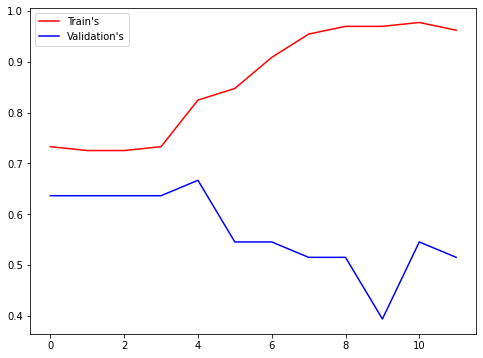

In [182]:
import matplotlib.pyplot as plt

trains = history.history["accuracy"]
vals = history.history["val_accuracy"]

plt.figure(figsize=(8, 6))
plt.plot(trains, c="red", label="Train's")
plt.plot(vals, c="blue", label="Validation's")
plt.legend()
plt.show()

모델 평가 기록을 하자.

- 0.7143: Embedding(10) -> Flatten() -> Dense(1)
- 0.2857: Embedding(10) -> Flatten() -> Dense(max_value) -> Dense(1)
- 0.8214: Embedding(10) -> Flatten() -> Dense(max_value) -> Dense(8) -> Dense(1)
- 0.7500: Embedding(10) -> Conv1D(64, 4) -> MaxPooling1D(2) -> Flatten() -> Dense(max_value) -> Dense(8) -> Dense(1)

validation_split 적용

- 0.9464: Embedding(10) -> Conv1D(64, 4) -> MaxPooling1D(2) -> Flatten() -> Dense(max_value) -> Dropout(0.3) -> Dense(10) -> Dense(1, "sigmoid")

EarlyStopping 적용

- 0.7321: Embedding(8) -> Conv1D(64, 4) -> MaxPooling1D(2) -> Flatten() -> Dropout(0.3) -> Dense(10) -> Dense(1, "sigmoid")
- 0.9286: Embedding(8) -> Conv1D(64, 4) -> Conv1D(128, 4) -> MaxPooling1D(2) -> Flatten() -> Dense(128) -> Dropout(0.3) -> Dense(10) -> Dense(1, "sigmoid")

이젠 아주 감각적으로 하려고 노력

- 0.9531: Embedding(8) -> Conv1D(32, 5) -> Conv1D(64, 5) -> MaxPooling1D(2) -> Dropout(0.3) -> Flatten() -> Dense(128) -> Dropout(0.3) -> Dense(10) -> Dense(1, "sigmoid")
- 0.9688: 
model = Sequential()
model.add(Embedding(word_count, 10, input_length=max_value))
model.add(Conv1D(32, kernel_size=5, activation="relu"))
model.add(Conv1D(64, kernel_size=5, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
stopping = EarlyStopping(patience=5, monitor="val_loss")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x, train_l, validation_split=0.2, batch_size=10, epochs=20, callbacks=[stopping])

원래 주제가 원하던 대로 두 데이터를 합쳐서 확인해보자.

In [160]:
tt = token.texts_to_sequences(test_s)
tt = pad_sequences(tt, max_value)
print("Accuracy: %.4f" % model.evaluate(tt, test_l)[1])

41/41 [==============================] - 0s 1ms/step
Accuracy: 0.7073
